In [32]:
import pandas as pd
from scipy import stats
import itertools

In [33]:
P_ROUND = 3
C_ROUND = 3

In [34]:
all_sheets = pd.read_excel("./data/gemma-3-12b-single-sun.xlsx", sheet_name=None)
# List to hold dataframes with prefixed columns
dfs = []
for sheet_name, df in all_sheets.items():
    # Prefix columns with sheet name
    df_prefixed = df.add_prefix(f"{sheet_name}_")
    dfs.append(df_prefixed)
# Concatenate all dataframes column-wise
gemma = pd.concat(dfs, axis=1)
del dfs  # Free up memory

In [35]:
gemma = gemma.set_index("letters_new_names")
gemma.index.rename("names")
# Extract scores from Gemma spreadsheet
gemma = gemma.loc[:, gemma.filter(regex="score").columns]

gemma.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, Oliviu Barbu to Loredana Diaconu
Data columns (total 90 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   letters_formal_and_structural_score_1                   562 non-null    int64  
 1   letters_formal_and_structural_score_2                   562 non-null    int64  
 2   letters_formal_and_structural_score_3                   562 non-null    int64  
 3   letters_formal_and_structural_score_4                   562 non-null    int64  
 4   letters_formal_and_structural_score_5                   562 non-null    int64  
 5   letters_formal_and_structural_final_score               562 non-null    object 
 6   letters_relevance_and_thematic_fit_score_1              562 non-null    int64  
 7   letters_relevance_and_thematic_fit_score_2              562 non-null    int64  
 8   letters_relevance_and

In [36]:
gemma_scores = pd.DataFrame()
# Recalculate mean scores
for score in gemma.filter(regex="final_score").columns:
    label = score.replace("_final_score", "")
    cols = gemma.filter(regex=f"{label}_score").columns
    gemma_scores[label] = gemma[cols].mean(axis=1)

gemma_scores.fillna(0, inplace=True)
gemma_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, Oliviu Barbu to Loredana Diaconu
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   letters_formal_and_structural               562 non-null    float64
 1   letters_relevance_and_thematic_fit          562 non-null    float64
 2   letters_professionalism_and_research        562 non-null    float64
 3   letters_uniqueness_and_individuality        562 non-null    float64
 4   letters_potential_and_developmental         562 non-null    float64
 5   presentations_formal_and_structural         562 non-null    float64
 6   presentations_relevance_and_thematic_fit    562 non-null    float64
 7   presentations_professionalism_and_research  562 non-null    float64
 8   presentations_uniqueness_and_individuality  562 non-null    float64
 9   presentations_potential_and_developmental   562 non-null    float64


In [37]:
human_scores = pd.read_parquet("./data/dataset.parquet")
human_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, Adam Mazilescu to Ștefania Albu
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cv                          571 non-null    object 
 1   letter                      572 non-null    object 
 2   presentation                568 non-null    object 
 3   cv_phd_1                    571 non-null    float64
 4   cv_phd_2                    571 non-null    float64
 5   letter_phd_1                571 non-null    float64
 6   letter_phd_2                571 non-null    float64
 7   pres_phd_1                  571 non-null    float64
 8   pres_phd_2                  571 non-null    float64
 9   pres_class                  571 non-null    float64
 10  video_phd_1                 387 non-null    float64
 11  video_phd_2                 413 non-null    float64
 12  all_phd_1                   571 non-null    float64
 13  all_phd_2        

In [38]:
# Compute mean scores
human_scores["phd_score"] = human_scores[["all_phd_1", "all_phd_2"]].mean(axis=1)
human_scores["cv_score"] = human_scores[["cv_phd_1", "cv_phd_2"]].mean(axis=1)
human_scores["pres_score"] = human_scores[["pres_phd_1", "pres_phd_2"]].mean(axis=1)
human_scores["letter_score"] = human_scores[["letter_phd_1", "letter_phd_2"]].mean(
    axis=1
)

human_scores["cv_len"] = human_scores["cv"].map(
    lambda x: len(x) if isinstance(x, str) else 0
)
human_scores["pres_len"] = human_scores["presentation"].map(
    lambda x: len(x) if isinstance(x, str) else 0
)
human_scores["letter_len"] = human_scores["letter"].map(
    lambda x: len(x) if isinstance(x, str) else 0
)

human_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 581 entries, Adam Mazilescu to Ștefania Albu
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cv                          571 non-null    object 
 1   letter                      572 non-null    object 
 2   presentation                568 non-null    object 
 3   cv_phd_1                    571 non-null    float64
 4   cv_phd_2                    571 non-null    float64
 5   letter_phd_1                571 non-null    float64
 6   letter_phd_2                571 non-null    float64
 7   pres_phd_1                  571 non-null    float64
 8   pres_phd_2                  571 non-null    float64
 9   pres_class                  571 non-null    float64
 10  video_phd_1                 387 non-null    float64
 11  video_phd_2                 413 non-null    float64
 12  all_phd_1                   571 non-null    float64
 13  all_phd_2        

### LLM scores vs PhD and Professors scores correlation

In [39]:
SELECTED_COLS = ["phd_score", "prof_score"]

In [40]:
def compute_correlations(
    output_table: pd.DataFrame,
    input_table: pd.DataFrame,
    type: str = "pearson",
    decimals: int = 3,
) -> pd.DataFrame:
    CORRELATIONS = {
        "pearson": stats.pearsonr,
        "spearman": stats.spearmanr,
        "kendall": stats.kendalltau,
    }
    assert type in CORRELATIONS.keys(), (
        f"The type of correlation must be one of them: {list(CORRELATIONS.keys())}. ",
        f"'{type}' given instead",
    )
    assert decimals > 0, "The number of decimals must be positive!"

    for row, col in itertools.product(output_table.index, output_table.columns):
        # Calculate Pearson correlation coefficient and p-value
        selection = input_table[[row, col]].copy().dropna(axis=0)
        coef, pvalue = stats.pearsonr(selection[row], selection[col])
        output_table.loc[row, col] = f"{coef:.{C_ROUND}f} ({pvalue:.{P_ROUND}f})"

    return output_table

In [41]:
overview_table = pd.merge(
    human_scores, gemma_scores, left_index=True, right_index=True, how="inner"
)

In [42]:
pearson = pd.DataFrame(index=gemma_scores.columns, columns=SELECTED_COLS)
pearson = compute_correlations(pearson, overview_table, "pearson")

In [43]:
spearman = pd.DataFrame(index=gemma_scores.columns, columns=SELECTED_COLS)
spearman = compute_correlations(spearman, overview_table, "spearman")

In [44]:
kendall = pd.DataFrame(index=gemma_scores.columns, columns=SELECTED_COLS)
kendall = compute_correlations(kendall, overview_table, "kendall")

In [45]:
pd.concat(
    [spearman, pearson, kendall], axis=1, keys=["spearman", "pearson", "kendalltau"]
)

spearman                  \
                                                phd_score      prof_score   
letters_formal_and_structural               0.228 (0.000)  -0.106 (0.298)   
letters_relevance_and_thematic_fit          0.375 (0.000)   0.100 (0.329)   
letters_professionalism_and_research        0.312 (0.000)   0.043 (0.677)   
letters_uniqueness_and_individuality        0.368 (0.000)   0.046 (0.652)   
letters_potential_and_developmental         0.374 (0.000)   0.017 (0.865)   
presentations_formal_and_structural         0.032 (0.441)   0.070 (0.495)   
presentations_relevance_and_thematic_fit    0.028 (0.504)   0.080 (0.432)   
presentations_professionalism_and_research  0.034 (0.416)   0.057 (0.575)   
presentations_uniqueness_and_individuality  0.049 (0.239)   0.098 (0.337)   
presentations_potential_and_developmental   0.039 (0.351)   0.062 (0.546)   
cv_formal_and_structural                    0.040 (0.346)   0.043 (0.674)   
cv_relevance_and_thematic_fit               0.032 (0.441)  -0.042 (0.682)   
cv_professionalism_and_research             0.050 (0.235)  -0.060 (0.559)   
cv_uniqueness_and_individuality             0.022 (0.596)  -0.051 (0.619)   
cv_potential_and_developmental              0.031 (0.468)  -0.056 (0.586)   

                                                  pearson                  \
                                                phd_score      prof_score   
letters_formal_and_structural               0.228 (0.000)  -0.106 (0.298)   
letters_relevance_and_thematic_fit          0.375 (0.000)   0.100 (0.329)   
letters_professionalism_and_research        0.312 (0.000)   0.043 (0.677)   
letters_uniqueness_and_individuality        0.368 (0.000)   0.046 (0.652)   
letters_potential_and_developmental         0.374 (0.000)   0.017 (0.865)   
presentations_formal_and_structural         0.032 (0.441)   0.070 (0.495)   
presentations_relevance_and_thematic_fit    0.028 (0.504)   0.080 (0.432)   
presentations_professionalism_and_research  0.034 (0.416)   0.057 (0.575)   
presentations_uniqueness_and_individuality  0.049 (0.239)   0.098 (0.337)   
presentations_potential_and_developmental   0.039 (0.351)   0.062 (0.546)   
cv_formal_and_structural                    0.040 (0.346)   0.043 (0.674)   
cv_relevance_and_thematic_fit               0.032 (0.441)  -0.042 (0.682)   
cv_professionalism_and_research             0.050 (0.235)  -0.060 (0.559)   
cv_uniqueness_and_individuality             0.022 (0.596)  -0.051 (0.619)   
cv_potential_and_developmental              0.031 (0.468)  -0.056 (0.586)   

                                               kendalltau                  
                                                phd_score      prof_score  
letters_formal_and_structural               0.228 (0.000)  -0.106 (0.298)  
letters_relevance_and_thematic_fit          0.375 (0.000)   0.100 (0.329)  
letters_professionalism_and_research        0.312 (0.000)   0.043 (0.677)  
letters_uniqueness_and_individuality        0.368 (0.000)   0.046 (0.652)  
letters_potential_and_developmental         0.374 (0.000)   0.017 (0.865)  
presentations_formal_and_structural         0.032 (0.441)   0.070 (0.495)  
presentations_relevance_and_thematic_fit    0.028 (0.504)   0.080 (0.432)  
presentations_professionalism_and_research  0.034 (0.416)   0.057 (0.575)  
presentations_uniqueness_and_individuality  0.049 (0.239)   0.098 (0.337)  
presentations_potential_and_developmental   0.039 (0.351)   0.062 (0.546)  
cv_formal_and_structural                    0.040 (0.346)   0.043 (0.674)  
cv_relevance_and_thematic_fit               0.032 (0.441)  -0.042 (0.682)  
cv_professionalism_and_research             0.050 (0.235)  -0.060 (0.559)  
cv_uniqueness_and_individuality             0.022 (0.596)  -0.051 (0.619)  
cv_potential_and_developmental              0.031 (0.468)  -0.056 (0.586)

### CV, Presenation and letters scores vs Phd and Professors scores Kendall tau

In [46]:
kendall_interdata = pd.DataFrame(
    index=["cv_len", "letter_len", "pres_len"],
    columns=["phd_score", "prof_score"],
)
for row, col in itertools.product(kendall_interdata.index, kendall_interdata.columns):
    # Calculate Kendall tau correlation coefficient and p-value
    selection = overview_table[[row, col]].copy().dropna(axis=0)
    coef, pvalue = stats.kendalltau(selection[row], selection[col])
    kendall_interdata.loc[row, col] = f"{coef:.{C_ROUND}f} ({pvalue:.{P_ROUND}f})"

kendall_interdata

,phd_score,prof_score
cv_len,0.163 (0.000),0.048 (0.507)
letter_len,0.161 (0.000),-0.095 (0.191)
pres_len,0.181 (0.000),-0.180 (0.013)


### Predictive strength of LLM scores

The predictive strength is defined as the correlation between LLM scores and results of online and offline tests.

In [47]:
spearman_test = pd.DataFrame(
    index=list(gemma_scores.columns) + ["phd_score", "prof_score"],
    columns=["online_test_score", "offline_test_total"],
)

spearman_test = compute_correlations(spearman_test, overview_table, "spearman")

In [48]:
kendall_test = pd.DataFrame(
    index=list(gemma_scores.columns) + ["phd_score", "prof_score"],
    columns=["online_test_score", "offline_test_total"],
)

kendall_test = compute_correlations(kendall_test, overview_table, "kendall")

In [49]:
pd.concat([spearman_test, kendall_test], axis=1, keys=["spearman", "kendalltau"])

spearman  \
                                           online_test_score   
letters_formal_and_structural                  0.081 (0.193)   
letters_relevance_and_thematic_fit             0.065 (0.293)   
letters_professionalism_and_research           0.084 (0.173)   
letters_uniqueness_and_individuality           0.086 (0.167)   
letters_potential_and_developmental            0.079 (0.204)   
presentations_formal_and_structural            0.057 (0.356)   
presentations_relevance_and_thematic_fit       0.069 (0.263)   
presentations_professionalism_and_research     0.062 (0.316)   
presentations_uniqueness_and_individuality     0.083 (0.178)   
presentations_potential_and_developmental      0.095 (0.125)   
cv_formal_and_structural                       0.025 (0.682)   
cv_relevance_and_thematic_fit                  0.047 (0.449)   
cv_professionalism_and_research                0.017 (0.782)   
cv_uniqueness_and_individuality                0.036 (0.562)   
cv_potential_and_developmental                 0.041 (0.510)   
phd_score                                      0.030 (0.631)   
prof_score                                    -0.268 (0.082)   

                                                               \
                                           offline_test_total   
letters_formal_and_structural                   0.018 (0.902)   
letters_relevance_and_thematic_fit              0.003 (0.984)   
letters_professionalism_and_research           -0.056 (0.706)   
letters_uniqueness_and_individuality           -0.077 (0.601)   
letters_potential_and_developmental            -0.185 (0.208)   
presentations_formal_and_structural            -0.126 (0.395)   
presentations_relevance_and_thematic_fit       -0.196 (0.183)   
presentations_professionalism_and_research     -0.054 (0.716)   
presentations_uniqueness_and_individuality     -0.181 (0.219)   
presentations_potential_and_developmental      -0.184 (0.210)   
cv_formal_and_structural                        0.022 (0.880)   
cv_relevance_and_thematic_fit                   0.186 (0.206)   
cv_professionalism_and_research                 0.094 (0.526)   
cv_uniqueness_and_individuality                 0.096 (0.516)   
cv_potential_and_developmental                  0.194 (0.186)   
phd_score                                       0.066 (0.655)   
prof_score                                     -0.018 (0.909)   

                                                  kendalltau  \
                                           online_test_score   
letters_formal_and_structural                  0.081 (0.193)   
letters_relevance_and_thematic_fit             0.065 (0.293)   
letters_professionalism_and_research           0.084 (0.173)   
letters_uniqueness_and_individuality           0.086 (0.167)   
letters_potential_and_developmental            0.079 (0.204)   
presentations_formal_and_structural            0.057 (0.356)   
presentations_relevance_and_thematic_fit       0.069 (0.263)   
presentations_professionalism_and_research     0.062 (0.316)   
presentations_uniqueness_and_individuality     0.083 (0.178)   
presentations_potential_and_developmental      0.095 (0.125)   
cv_formal_and_structural                       0.025 (0.682)   
cv_relevance_and_thematic_fit                  0.047 (0.449)   
cv_professionalism_and_research                0.017 (0.782)   
cv_uniqueness_and_individuality                0.036 (0.562)   
cv_potential_and_developmental                 0.041 (0.510)   
phd_score                                      0.030 (0.631)   
prof_score                                    -0.268 (0.082)   

                                                               
                                           offline_test_total  
letters_formal_and_structural                   0.018 (0.902)  
letters_relevance_and_thematic_fit              0.003 (0.984)  
letters_professionalism_and_research           -0.056 (0.706)  
letters_uniqueness_and_individuality           -0.077 (0.601) 

### Assessors correlations

In [50]:
phd_corr = pd.DataFrame(
    index=["all_phd_1", "cv_phd_1", "letter_phd_1", "pres_phd_1"],
    columns=["all_phd_2", "cv_phd_2", "letter_phd_2", "pres_phd_2"],
)

phd_corr = compute_correlations(phd_corr, human_scores, "pearson")
phd_corr

,all_phd_2,cv_phd_2,letter_phd_2,pres_phd_2
all_phd_1,0.852 (0.000),0.568 (0.000),0.608 (0.000),0.731 (0.000)
cv_phd_1,0.553 (0.000),0.693 (0.000),0.476 (0.000),0.463 (0.000)
letter_phd_1,0.561 (0.000),0.441 (0.000),0.708 (0.000),0.456 (0.000)
pres_phd_1,0.706 (0.000),0.466 (0.000),0.511 (0.000),0.727 (0.000)


In [51]:
assessors_corr = pd.DataFrame(index=["phd_score"], columns=["prof_score"])

assessors_corr = compute_correlations(assessors_corr, human_scores, "pearson")
assessors_corr

,prof_score
phd_score,0.243 (0.016)


## ROC-AUC for binary scores

In [52]:
from sklearn.metrics import roc_auc_score

### ROC-AUC between students features and their participation in school and projects
(wihtout considering their participation status)

In [53]:
classification = pd.DataFrame(
    index=list(gemma_scores.columns) + ["phd_score", "prof_score"],
    columns=["project_participation_flag", "school_participation_flag"],
)
for row, col in itertools.product(classification.index, classification.columns):
    # Calculate Pearson correlation coefficient and p-value
    selection = overview_table[[row, col]].copy().dropna(axis=0)
    auroc = roc_auc_score(selection[col], selection[row])
    classification.loc[row, col] = f"{auroc:.{C_ROUND}f}"

classification

,project_participation_flag,school_participation_flag
letters_formal_and_structural,0.523,0.536
letters_relevance_and_thematic_fit,0.539,0.578
letters_professionalism_and_research,0.547,0.565
letters_uniqueness_and_individuality,0.597,0.583
letters_potential_and_developmental,0.549,0.608
presentations_formal_and_structural,0.513,0.519
presentations_relevance_and_thematic_fit,0.516,0.506
presentations_professionalism_and_research,0.515,0.509
presentations_uniqueness_and_individuality,0.533,0.496
presentations_potential_and_developmental,0.565,0.506


### Online students participation in projects

In [54]:
online_table = overview_table[overview_table["offline_test_total"].isna()]
online_table = online_table[online_table["school_participation_flag"]]

In [55]:
classification = pd.DataFrame(
    index=list(gemma_scores.columns) + ["phd_score", "prof_score"],
    columns=["project_participation_flag"],
)
for row, col in itertools.product(classification.index, classification.columns):
    # Calculate Pearson correlation coefficient and p-value
    selection = online_table[[row, col]].copy().dropna(axis=0)
    auroc = roc_auc_score(selection[col], selection[row])
    classification.loc[row, col] = f"{auroc:.{C_ROUND}f}"

classification

,project_participation_flag
letters_formal_and_structural,0.500
letters_relevance_and_thematic_fit,0.484
letters_professionalism_and_research,0.507
letters_uniqueness_and_individuality,0.557
letters_potential_and_developmental,0.472
presentations_formal_and_structural,0.502
presentations_relevance_and_thematic_fit,0.515
presentations_professionalism_and_research,0.508
presentations_uniqueness_and_individuality,0.541
presentations_potential_and_developmental,0.572


In [56]:
features = classification.index
mapper = {}
for feature in features:
    label = feature.replace("_", " ").replace("and", "&").title()
    label = label.replace("Letters", "Motivational letter").replace("Presentations", "Presentation")
    label = label.replace("Phd", "PhD").replace("Prof", "Professor")
    mapper[feature] = label.replace("Cv", "CV")

classification = classification.rename(index=mapper)
classification = classification.astype(float)
classification

,project_participation_flag
Motivational letter Formal & Structural,0.500
Motivational letter Relevance & Thematic Fit,0.484
Motivational letter Professoressionalism & Research,0.507
Motivational letter Uniqueness & Individuality,0.557
Motivational letter Potential & Developmental,0.472
Presentation Formal & Structural,0.502
Presentation Relevance & Thematic Fit,0.515
Presentation Professoressionalism & Research,0.508
Presentation Uniqueness & Individuality,0.541
Presentation Potential & Developmental,0.572


In [57]:
from matplotlib import pyplot as plt

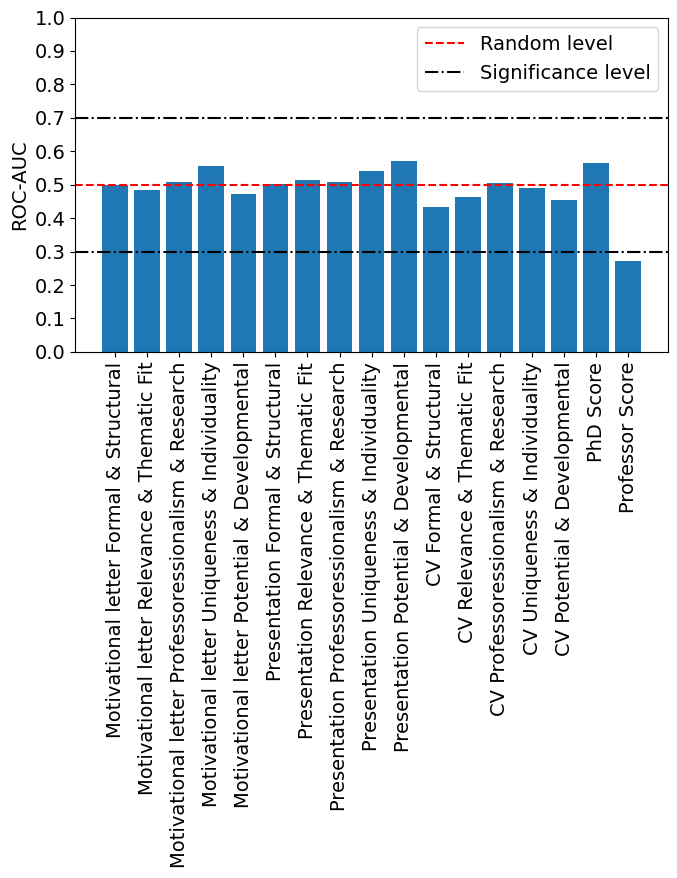

In [58]:
plt.rcParams["font.size"] = 14

fig = plt.figure(figsize=(7, 9))
plt.bar(classification.index, height=classification["project_participation_flag"])

plt.axhline(0.5, linestyle="--", color="r", label="Random level")
plt.axhline(0.3, linestyle="-.", color="k", label="Significance level")
plt.axhline(0.7, linestyle="-.", color="k")

plt.xticks(rotation=90)
plt.ylabel("ROC-AUC")
plt.ylim(0, 1)
plt.yticks([0.1 * i for i in range(11)])

plt.tight_layout()
plt.legend()
plt.show()

fig.savefig("./output/binary_roc_auc.pdf", dpi=300)

In [59]:
online_table.shape

(261, 48)